In [3]:
!pip3 install torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 MB 6.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 7.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 3.3 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 19.4 MB/s eta 0:00:00

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip3 install --upgrade pip


In [8]:
!pip3 install gymnasium stable-baselines3


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip3 install --upgrade pip


In [1]:
import os, random, numpy as np, torch
import matplotlib.pyplot as plt
import time
import gymnasium as gym
from gymnasium import spaces
from typing import Callable, Optional, Dict, Any, Tuple
import numpy as np

from oceanrl import query  # query(salmon, shark, effort, month)

# Stable-Baselines3
from stable_baselines3 import SAC
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnNoModelImprovement

SEED = 2025
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [2]:
class FishingEnvContinuous(gym.Env):
    metadata = {"render_modes": []}
    def __init__(
        self,
        *,
        salmon_t0: float,
        shark_t0: float,
        query: Callable[[float, float, float, int], Tuple[float, float, float]],
        max_month: int = 900,
        # reward weights
        K1: float = 1e-3,
        K2: float = 1e-2,
        K3: float = 100.0,
        K4: float = 100.0,
        # obs normalization
        obs_mode: str = "ratio",
        ema_decay: float = 0.995,
        clip_factor: float = 5.0,
        # effort cap
        effort_cap: Optional[float] = None,
        effort_probe_grid: int = 15,
        seed: Optional[int] = None,
    ):
        super().__init__()
        self.rng = np.random.default_rng(seed)

        self.salmon0 = float(salmon_t0)
        self.shark0  = float(shark_t0)
        self.max_month = int(max_month)
        self.query = query

        self.K1, self.K2, self.K3, self.K4 = float(K1), float(K2), float(K3), float(K4)

        # continuous action: effort in [0, E_max]
        self._E_max = float(effort_cap) if effort_cap is not None else None
        # observation normalization
        self.obs_mode = obs_mode
        self.ema_decay = float(ema_decay)
        self.clip_factor = float(clip_factor)
        self.s_ema = max(self.salmon0, 1e-6)
        self.k_ema = max(self.shark0,  1e-6)

        self.observation_space = spaces.Box(low=0.0, high=1.0, shape=(3,), dtype=np.float32)
        # action is Box(1,), we map [0,1] -> [0,E_max]
        self.action_space = spaces.Box(low=np.array([0.0], dtype=np.float32),
                                       high=np.array([1.0], dtype=np.float32),
                                       dtype=np.float32)

        self.salmon = self.salmon0
        self.shark  = self.shark0
        self.month  = 1

        if self._E_max is None:
            self._E_max = self._autotune_effort_cap(probe_grid=effort_probe_grid)

    # ---------- helpers ----------
    def _a_to_effort(self, a: np.ndarray) -> float:
        # a in [0,1] -> [0, E_max]
        a01 = float(np.clip(a[0], 0.0, 1.0))
        return a01 * self._E_max

    def _step_reward(self, caught: float, effort: float) -> float:
        return self.K1 * float(caught) - self.K2 * float(effort)

    def _terminal_bonus(self) -> float:
        eps = 1e-10
        return self.K3 * np.log(max(self.salmon, eps)) + self.K4 * np.log(max(self.shark, eps))

    def _update_scales(self, s: float, k: float):
        self.s_ema = self.ema_decay * self.s_ema + (1 - self.ema_decay) * max(s, 1e-6)
        self.k_ema = self.ema_decay * self.k_ema + (1 - self.ema_decay) * max(k, 1e-6)

    def _norm_obs(self, s: float, k: float, m: int) -> np.ndarray:
        self._update_scales(s, k)
        if self.obs_mode == "log":
            s_n = np.log1p(s) / np.log1p(self.clip_factor * self.s_ema)
            k_n = np.log1p(k) / np.log1p(self.clip_factor * self.k_ema)
        else:
            s_n = s / (self.clip_factor * self.s_ema)
            k_n = k / (self.clip_factor * self.k_ema)
        s_n = float(np.clip(s_n, 0.0, 1.0))
        k_n = float(np.clip(k_n, 0.0, 1.0))
        m_n = float(np.clip(m / self.max_month, 0.0, 1.0))
        return np.array([s_n, k_n, m_n], dtype=np.float32)

    def _autotune_effort_cap(self, probe_grid: int = 15) -> float:
        guess = max(5.0, 0.001 * self.salmon0)
        efforts = np.linspace(0.0, guess * 10.0, probe_grid)
        best_r, best_e = -np.inf, efforts[0]
        s, k, m = self.salmon0, self.shark0, 1
        for e in efforts:
            sc, s1, k1 = self.query(s, k, float(e), m)
            r = self._step_reward(sc, e)
            if r > best_r:
                best_r, best_e = r, float(e)
        return float(max(5.0, best_e * 2.0))

    # ---------- gym API ----------
    def reset(self, *, seed: Optional[int] = None, options: Optional[Dict[str, Any]] = None):
        if seed is not None:
            self.rng = np.random.default_rng(seed)
        self.salmon = self.salmon0
        self.shark  = self.shark0
        self.month  = 1
        self.s_ema = max(self.salmon0, 1e-6)
        self.k_ema = max(self.shark0,  1e-6)
        obs = self._norm_obs(self.salmon, self.shark, self.month)
        return obs, {}

    def step(self, action: np.ndarray):
        effort = self._a_to_effort(action)
        sc, s1, k1 = self.query(self.salmon, self.shark, float(effort), self.month)
        reward = self._step_reward(sc, effort)
        self.salmon, self.shark = float(s1), float(k1)
        self.month += 1
        terminated = self.month > self.max_month
        if terminated:
            reward += self._terminal_bonus()
        obs = self._norm_obs(self.salmon, self.shark, self.month)
        info = {"effort": float(effort), "salmon_caught": float(sc), "E_max": float(self._E_max)}
        return obs, float(reward), bool(terminated), False, info

    def render(self):
        print(f"t={self.month:3d} | salmon={self.salmon:.3f} | shark={self.shark:.3f}")



In [3]:
def make_env(seed=SEED):
    env = FishingEnvContinuous(
        salmon_t0=20000.0,
        shark_t0=500.0,
        query=query,
        max_month=900,
        K1=1e-3, K2=1e-2, K3=100.0, K4=100.0,
        obs_mode="ratio",
        ema_decay=0.995,
        clip_factor=5.0,
        effort_cap=None,
        effort_probe_grid=15,
        seed=seed,
    )
    env = Monitor(env)
    env.reset(seed=seed)
    if hasattr(env, "action_space"): env.action_space.seed(seed)
    if hasattr(env, "observation_space"): env.observation_space.seed(seed)
    return env

train_env = make_env(SEED)
eval_env  = make_env(SEED)

policy_kwargs = dict(net_arch=[256, 256, 128], activation_fn=torch.nn.ReLU)

model = SAC(
    "MlpPolicy",
    train_env,
    policy_kwargs=policy_kwargs,
    learning_rate=1e-3,
    buffer_size=1_000_000,
    batch_size=2048,
    train_freq=4,
    gradient_steps=2,
    tau=0.05,
    gamma=1,
    ent_coef="auto",
    target_update_interval=1,
    verbose=1,
    seed=SEED,
)

early_stop = StopTrainingOnNoModelImprovement(
    max_no_improvement_evals=20,
    verbose=1
)

eval_cb = EvalCallback(
    eval_env,
    best_model_save_path="./best_sac/",
    log_path="./logs/",
    eval_freq=10_000,
    n_eval_episodes=5,
    deterministic=True,
    callback_after_eval=early_stop,
)



Using cpu device
Wrapping the env in a DummyVecEnv.


In [6]:
# --- Train ---
set_random_seed(SEED)

t0 = time.perf_counter()
model.learn(total_timesteps=1_000_000, callback=eval_cb)
print(f"[TRAIN] Elapsed: {time.perf_counter()-t0:.2f}s")


----------------------------------
| rollout/           |           |
|    ep_len_mean     | 900       |
|    ep_rew_mean     | -1.74e+03 |
| time/              |           |
|    episodes        | 4         |
|    fps             | 126       |
|    time_elapsed    | 28        |
|    total_timesteps | 3600      |
| train/             |           |
|    actor_loss      | 1.23e+03  |
|    critic_loss     | 106       |
|    ent_coef        | 9.03      |
|    ent_coef_loss   | 0.0319    |
|    learning_rate   | 0.001     |
|    n_updates       | 334394    |
----------------------------------
Eval num_timesteps=4604, episode_reward=12378.86 +/- 16.19
Episode length: 900.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 900      |
|    mean_reward     | 1.24e+04 |
| time/              |          |
|    total_timesteps | 4604     |
| train/             |          |
|    actor_loss      | 1.22e+03 |
|    critic_loss     | 79.9     |
|    ent

In [4]:
best = SAC.load("./best_sac/best_model.zip")

In [9]:
def evaluate_returns(model, env, episodes: int = 1000):
    returns = []
    episode_stats = []
    for ep in range(episodes):
        obs, _ = env.reset()
        done = False
        ep_ret = 0.0
        salmon_caught = 0.0
        total_effort = 0.0
        final_salmon = float("nan")
        final_shark = float("nan")

        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = env.step(action)
            ep_ret += float(reward)
            salmon_caught += float(info.get("salmon_caught", 0.0))
            total_effort += float(info.get("effort", 0.0))
            done = terminated or truncated
            if done:
                base_env = env.unwrapped
                final_salmon = float(getattr(base_env, "salmon", float("nan")))
                final_shark = float(getattr(base_env, "shark", float("nan")))

        returns.append(ep_ret)
        episode_stats.append(
            dict(
                episode=ep + 1,
                salmon_caught=salmon_caught,
                effort=total_effort,
                final_salmon=final_salmon,
                final_shark=final_shark,
                reward=ep_ret,
            )
        )

    arr = np.asarray(returns, dtype=np.float64)
    stats = {
        "episodes": int(episodes),
        "mean": float(arr.mean()),
        "median": float(np.median(arr)),
        "std": float(arr.std(ddof=1)) if episodes > 1 else 0.0,
        "min": float(arr.min()),
        "max": float(arr.max()),
    }
    return returns, stats, episode_stats

returns, stats, episode_stats = evaluate_returns(best, eval_env, episodes=1000)
print("[EVAL] Episodes:", stats["episodes"])
print(f"[EVAL] Mean: {stats['mean']:.2f}  Median: {stats['median']:.2f}  Std: {stats['std']:.2f}")
print(f"[EVAL] Min: {stats['min']:.2f}  Max: {stats['max']:.2f}")


avg_salmon = np.mean([row["salmon_caught"] for row in episode_stats])
avg_effort = np.mean([row["effort"] for row in episode_stats])
avg_final_salmon = np.mean([row["final_salmon"] for row in episode_stats])
avg_final_shark = np.mean([row["final_shark"] for row in episode_stats])

print(
    f"\nAverages over {stats['episodes']} episodes:\n"
    f"  salmon_caught = {avg_salmon:.0f}\n"
    f"  effort        = {avg_effort:.0f}\n"
    f"  final_salmon  = {avg_final_salmon:.0f}\n"
    f"  final_shark   = {avg_final_shark:.0f}"
)


[EVAL] Episodes: 1000
[EVAL] Mean: 12435.63  Median: 12435.84  Std: 39.63
[EVAL] Min: 12297.21  Max: 12567.60

Averages over 1000 episodes:
  salmon_caught = 13732557
  effort        = 10757
  final_salmon  = 68361
  final_shark   = 0


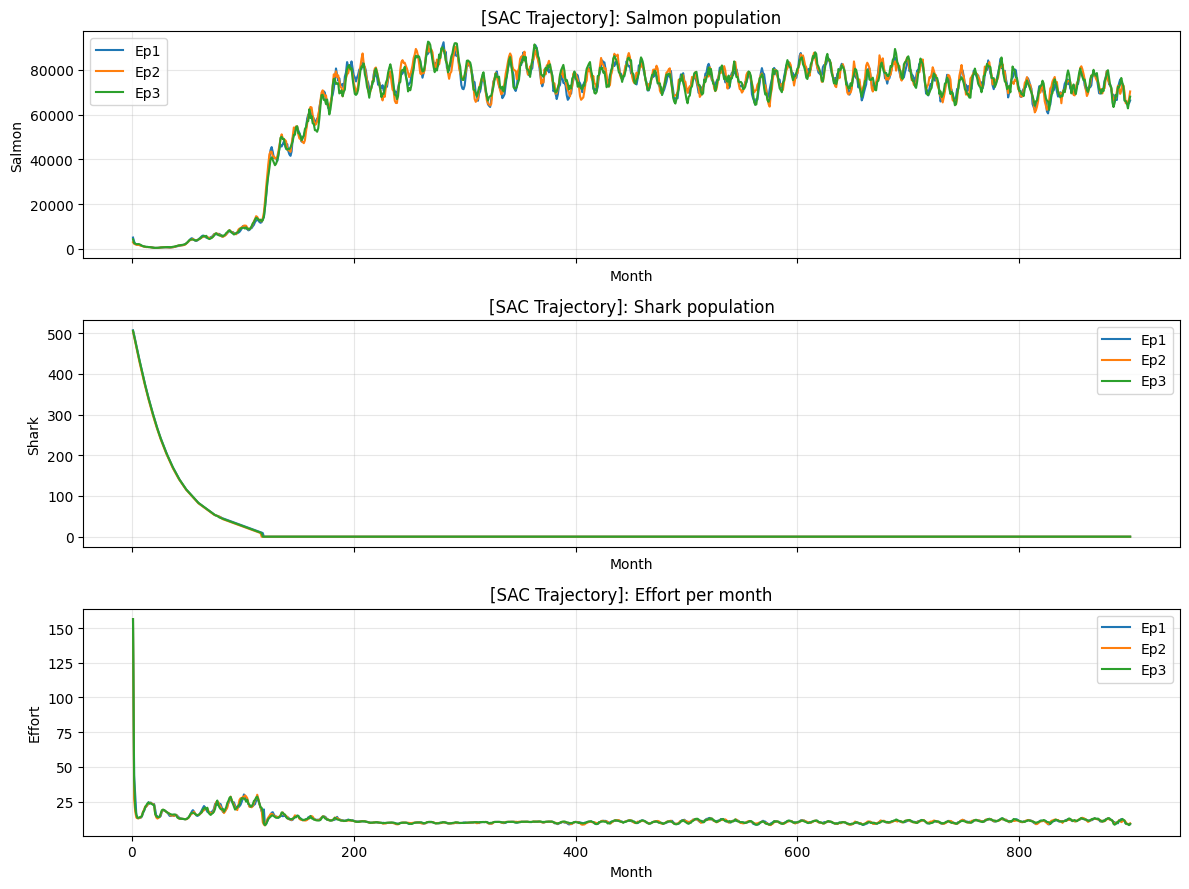

In [9]:
def eval_and_plot_full_trajectories(model, env, episodes=3, title_prefix="[SAC Trajectory]"):
    def unwrap_env(env):
        base_env = env
        while hasattr(base_env, 'env'):
            base_env = base_env.env
        return base_env

    fig, axes = plt.subplots(3, 1, figsize=(12, 9), sharex=True)
    for ep in range(episodes):
        obs, _ = env.reset()
        s_hist, k_hist, e_hist, r_hist, months = [], [], [], [], []
        done = False
        while not done:
            base_env = unwrap_env(env)
            months.append(getattr(base_env, "month", len(months)+1))
            action, _ = model.predict(obs, deterministic=True)
            obs2, reward, terminated, truncated, info = env.step(action)
            s_hist.append(float(getattr(base_env, "salmon", float('nan'))))
            k_hist.append(float(getattr(base_env, "shark", float('nan'))))
            e_hist.append(float(info.get("effort", float(action[0]))))
            r_hist.append(float(reward))
            obs = obs2
            done = terminated or truncated
        axes[0].plot(months, s_hist, label=f"Ep{ep+1}")
        axes[1].plot(months, k_hist, label=f"Ep{ep+1}")
        axes[2].plot(months, e_hist, label=f"Ep{ep+1}")
    axes[0].set_title(f"{title_prefix}: Salmon population")
    axes[1].set_title(f"{title_prefix}: Shark population")
    axes[2].set_title(f"{title_prefix}: Effort per month")
    for ax, ylabel in zip(axes, ["Salmon", "Shark", "Effort"]):
        ax.set_xlabel("Month"); ax.set_ylabel(ylabel); ax.grid(True, alpha=0.3); ax.legend()
    plt.tight_layout(); plt.show()

eval_and_plot_full_trajectories(best, eval_env, episodes=3)



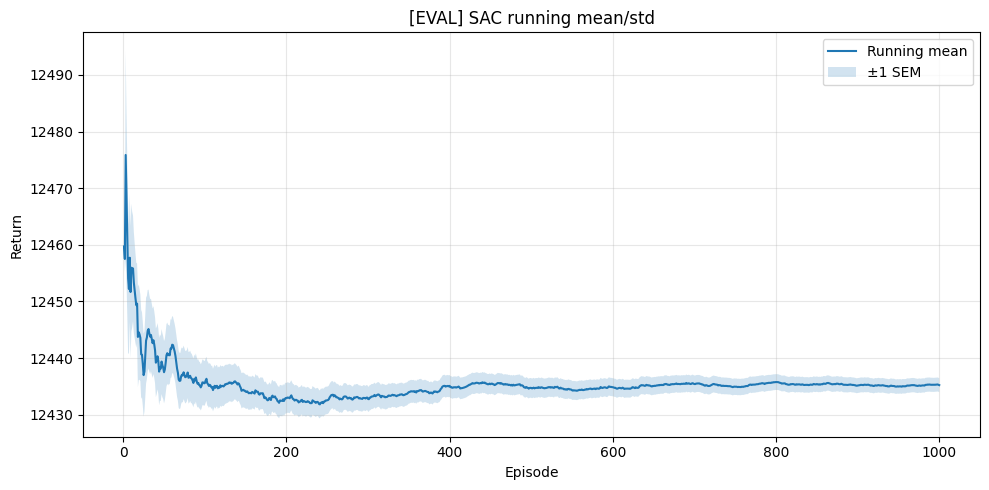

In [10]:
def plot_running_stats(returns, title="[EVAL] SAC running mean/std"):
    
    r = np.asarray(returns, dtype=np.float64)
    N = r.size
    idx = np.arange(1, N + 1)
    run_mean = np.cumsum(r) / idx
    run_std = np.zeros(N, dtype=np.float64)
    for k in range(2, N + 1):
        run_std[k - 1] = r[:k].std(ddof=1)
    with np.errstate(divide='ignore', invalid='ignore'):
        run_sem = np.where(idx > 1, run_std / np.sqrt(idx), 0.0)

    plt.figure(figsize=(10,5))
    plt.plot(idx, run_mean, label="Running mean")
    plt.fill_between(idx, run_mean - run_sem, run_mean + run_sem, alpha=0.2, label="±1 SEM")
    plt.xlabel("Episode"); plt.ylabel("Return"); plt.title(title); plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

plot_running_stats(returns)



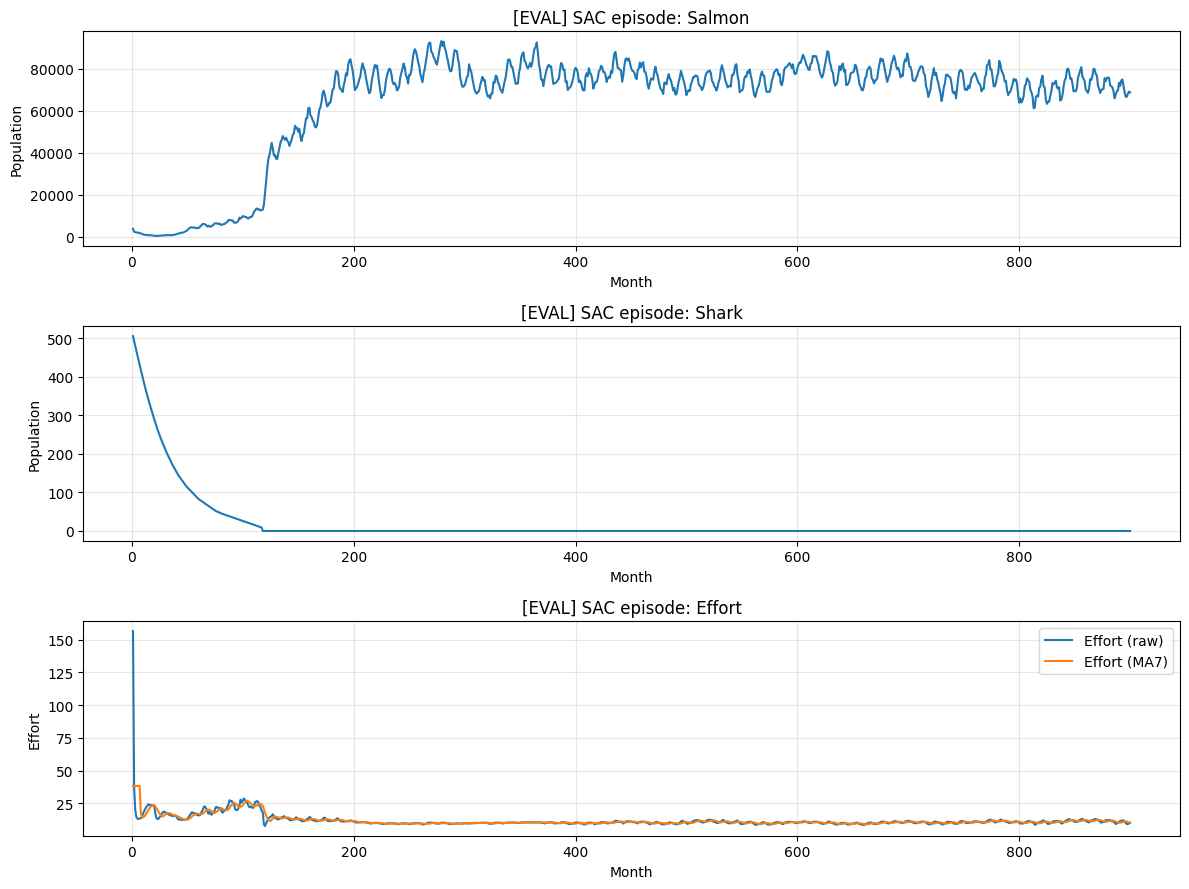

Sample episode return: 12460.296013362075


In [11]:
def rollout_one_episode_and_plot(model, env, smooth_effort_window=7, title_prefix="[EVAL] SAC episode"):
    def unwrap_env(env):
        base_env = env
        while hasattr(base_env, "env"):
            base_env = base_env.env
        return base_env
    
    obs, _ = env.reset()
    terminated = truncated = False
    months, salmon_hist, shark_hist, effort_hist, reward_hist = [], [], [], [], []
    while not (terminated or truncated):
        base_env = unwrap_env(env)
        months.append(getattr(base_env, "month", len(months)+1))
        action, _ = model.predict(obs, deterministic=True)
        new_obs, reward, terminated, truncated, info = env.step(action)
        reward_hist.append(float(reward))
        effort_hist.append(float(info.get("effort", float(action[0]))))
        salmon_hist.append(float(getattr(base_env, "salmon", float("nan"))))
        shark_hist.append(float(getattr(base_env, "shark", float("nan"))))
        obs = new_obs
    def _moving_avg(x, k):
        if k <= 1 or len(x) < 2: return np.asarray(x, dtype=float)
        x = np.asarray(x, dtype=float)
        k = min(k, len(x)); c = np.cumsum(np.insert(x, 0, 0.0))
        ma = (c[k:] - c[:-k]) / float(k)
        pad_left = np.full(k - 1, ma[0], dtype=float)
        return np.concatenate([pad_left, ma])
    effort_smooth = _moving_avg(effort_hist, smooth_effort_window)
    nrows = 3
    plt.figure(figsize=(12,9))
    ax1 = plt.subplot(nrows,1,1)
    if salmon_hist: ax1.plot(months, salmon_hist); ax1.set_title(f"{title_prefix}: Salmon"); ax1.set_xlabel("Month"); ax1.set_ylabel("Population"); ax1.grid(True, alpha=0.3)
    ax2 = plt.subplot(nrows,1,2, sharex=ax1)
    if shark_hist: ax2.plot(months, shark_hist); ax2.set_title(f"{title_prefix}: Shark"); ax2.set_xlabel("Month"); ax2.set_ylabel("Population"); ax2.grid(True, alpha=0.3)
    ax3 = plt.subplot(nrows,1,3, sharex=ax1)
    ax3.plot(months, effort_hist, label="Effort (raw)")
    if len(effort_hist) >= 2: ax3.plot(months, effort_smooth, label=f"Effort (MA{min(smooth_effort_window, len(effort_hist))})")
    ax3.set_title(f"{title_prefix}: Effort"); ax3.set_xlabel("Month"); ax3.set_ylabel("Effort"); ax3.grid(True, alpha=0.3); ax3.legend()
    plt.tight_layout(); plt.show()
    return {
        "months": months,
        "salmon": salmon_hist if salmon_hist else None,
        "shark": shark_hist if shark_hist else None,
        "effort": effort_hist,
        "effort_smooth": effort_smooth,
        "ep_return": float(np.sum(reward_hist)),
    }

traj = rollout_one_episode_and_plot(best, eval_env)
print("Sample episode return:", traj["ep_return"])

